The usual OO implementation of a cube with numpy for the data. It only stores the top-left-back most point in a 3D space where the origin is the top-left-back most point, and has another variable for the size of the Cube. The only function that can be applied is `push_up` which will push the cube up (the y-axis component will decrease)

In [19]:
import random

import numpy as np
from typing import Iterable
import time

from matplotlib import pyplot as plt
from tqdm import trange

In [20]:
class Cube:
    top_left_back_point: np.array
    size: int

    def __init__(self, top_left_back_point: tuple[int, int, int], size: int):
        self.top_left_back_point = np.array(top_left_back_point)
        self.size = size

    def push_up(self, amount: int):
        self.top_left_back_point[1] = max(0, self.top_left_back_point[1] - amount)

Then we can instantiate cubes 

In [21]:
def instantiate_cubes(nb=100):
    cubes = []
    for i in range(nb):
        cubes.append(Cube((i, i*2, i*3), 1))
    return cubes

In [22]:
cubes = instantiate_cubes()
print(cubes[43].top_left_back_point)
print(cubes[43].size)
cubes[43].push_up(26)
print(cubes[43].top_left_back_point)

[ 43  86 129]
1
[ 43  60 129]


Implemanting a handler for the data of all the cubes using numpy


In [23]:
class CubeHandler:
    instances: np.array = np.empty(dtype=Cube, shape=20)
    top_left_back_points: np.array = np.empty(dtype=int, shape=(200, 3))
    sizes: np.array = np.empty(dtype=int, shape=200)
    next_index = 0

    @staticmethod
    def get_next_index():
        index = CubeHandler.next_index
        if index >= len(CubeHandler.instances):
            # Extending the arrays
            CubeHandler.top_left_back_points = np.append(CubeHandler.top_left_back_points, np.empty_like(CubeHandler.top_left_back_points), axis=0)
            CubeHandler.sizes = np.append(CubeHandler.sizes, np.empty_like(CubeHandler.sizes))
            CubeHandler.instances = np.append(CubeHandler.instances, np.empty_like(CubeHandler.instances))
        CubeHandler.next_index += 1
        return index

Then, we can reimplement the Cube without its main attributes

In [24]:
StandaloneCube = Cube
class Cube:
    def __init__(self, top_left_back_point: tuple[int, int, int], size: int):
        self.__index = CubeHandler.get_next_index()
        CubeHandler.top_left_back_points[self.__index] = top_left_back_point
        CubeHandler.sizes[self.__index] = size
        CubeHandler.instances[self.__index] = self

    def push_up(self, amount: int):
        if self is None:
            self = CubeHandler.instances
        if isinstance(self, Cube):
            self = [self]

        for cube in self:
            if cube is None:
                continue
            cube.top_left_back_point[1] = max(0, cube.top_left_back_point[1] - amount)

    @property
    def top_left_back_point(self):
        return CubeHandler.top_left_back_points[self.__index]

    @top_left_back_point.setter
    def top_left_back_point(self, value: tuple[int, int, int]):
        CubeHandler.top_left_back_points[self.__index] = value

    @property
    def size(self):
        return CubeHandler.sizes[self.__index]

    @size.setter
    def size(self, value: int):
        CubeHandler.sizes[self.__index] = value


In [25]:
cubes = instantiate_cubes()
print(cubes[43].top_left_back_point)
print(cubes[43].size)
cubes[43].push_up(26)
print(cubes[43].top_left_back_point)

[ 43  86 129]
1
[ 43  60 129]


The interface is the same, but now comes with an advantage of being able to apply functions on the data more efficiently

In [26]:
cubes = instantiate_cubes()
print(list(x.top_left_back_point[1] for x in cubes[10:20]))
Cube.push_up(cubes, 5)
print(list(x.top_left_back_point[1] for x in cubes[10:20]))

[20, 22, 24, 26, 28, 30, 32, 34, 36, 38]
[15, 17, 19, 21, 23, 25, 27, 29, 31, 33]


In [27]:
print(len(CubeHandler.instances))
CubeHandler.get_next_index()

320


200

But we can also use a fast implementation of the same function that would be much slower in OO

In [28]:
nb_cubes = 1000
nb_iter = 100

In [29]:
all_cubes = [[Cube((j, j*2, j*3), 100) for j in range(nb_cubes)] for i in range(nb_iter)]  # Generate before starting the timer
start = time.perf_counter()
for i in trange(nb_iter):
    cubes = all_cubes[i]
    Cube.push_up(cubes, 5)
print((time.perf_counter() - start)/10)

100%|██████████| 100/100 [00:00<00:00, 478.36it/s]

0.021212556499995115


In [30]:
all_cubes = [[Cube((j, j*2, j*3), 100) for j in range(nb_cubes)] for i in range(nb_iter)]  # Generate before starting the timer
start = time.perf_counter()
for i in trange(nb_iter):
    cubes = all_cubes[i]
    for cube in cubes:
        cube.push_up(5)
print((time.perf_counter() - start)/10)

100%|██████████| 100/100 [00:00<00:00, 365.19it/s]

0.02768227550004667


There is a small overhead when using this paradigm, but the advantage is that we can take advantages of the fact that in some context, we will have to apply the same mathematical transformation to a number of adjacent indexes and this can be optimized, whereas in the case of 1 function call = 1 modification, it would be more complex to apply some optimizations

In [31]:
import threading

def parallel_push_up(self, amount):
    for cube in self:
        if cube is None:
            continue
        cube.top_left_back_point[1] = max(0, cube.top_left_back_point[1] - amount)
    return self

def push_up_multi(self, amount):
    if self is None:
        self = CubeHandler.instances
    if isinstance(self, Cube):
        self = [self]
    threads = []
    for i in range(4):
        start = i*len(self)//4
        stop = (i+1)*len(self)//4
        threads.append(threading.Thread(target=parallel_push_up, args=(self[start:stop], amount)))
        threads[-1].start()
    for t in threads:
        t.join()


Using the threading library we can take advantage of the batch processing by splitting the computation on multiple thread. This is a nutshell example, and the real power would be to offset the computation to multiple computers.
We can then replace the push_up method with this one and try again

In [32]:
ParallelCube = Cube
ParallelCube.push_up = push_up_multi

all_cubes = [[Cube((j, j*2, j*3), 100) for j in range(nb_cubes)] for i in range(nb_iter)]  # Generate before starting the timer
start = time.perf_counter()
for i in trange(nb_iter):
    cubes = all_cubes[i]
    Cube.push_up(cubes, 5)
print((time.perf_counter() - start)/10)

100%|██████████| 100/100 [00:00<00:00, 303.48it/s]

0.03408413189999919


This, once again, adds a small overhead to the previous implementation for small values, but the execution speed should speed up on bigger examples

However, we did not take into consideration the different size of the data, as well as the state of CubeHandler that is never truly reset which can lower the performance. Therefore, we will now compare on truly independents runs the different methods. Let's rename them first

In [33]:
OCube = StandaloneCube  # Pure Object-Oriented Cube
DCube = Cube  # Delegation Cube
PCube = ParallelCube  # Parallel Cube with the different push_up function

We'll run each iteration 30 times. During each iteration, we will repeat 10 times the operation with each size of data. The size of data will vary from 10 to 10 000 000 cubes. We also define a function to reset the state of the CubeHandler class.

In [34]:
data_sizes = [10**i for i in range(7)]
nb_sub_iter = 10  # Iterations with the same input size
nb_iter = 30

seed = "OOClimatology"

def reset_CubeHandler():
    CubeHandler.instances= np.empty(dtype=Cube, shape=20)
    CubeHandler.top_left_back_points = np.empty(dtype=int, shape=(200, 3))
    CubeHandler.sizes= np.empty(dtype=int, shape=200)
    CubeHandler.next_index = 0

times = {"O": {d_s: 0 for d_s in data_sizes},
         "D": {d_s: 0 for d_s in data_sizes},
         "P": {d_s: 0 for d_s in data_sizes}}

Let's first run the process on the default OO Cube

In [35]:

for d_s_i in trange(len(data_sizes)):
    start = time.perf_counter()
    data_size = data_sizes[d_s_i]
    for itr in range(nb_iter):
        start = time.perf_counter()
        for sub_itr in range(nb_sub_iter):
            cubes = [OCube(tuple(random.randint(0, 1000) for _ in range(3)), random.randint(1, 150)) for _ in range(data_size)]
            for cube in cubes:
                cube.push_up(random.randint(1, 150))
        times["O"][data_size] += time.perf_counter() - start
for k, v in times["O"].items():
    print(f"Input size {k}: {v/nb_iter/nb_sub_iter}")

100%|██████████| 7/7 [1:07:10<00:00, 575.79s/it] 

Input size 1: 1.5088223323497612e-05
Input size 10: 0.00014470010334055892
Input size 100: 0.0011735531466698982
Input size 1000: 0.011848211963327533
Input size 10000: 0.12403706019001219
Input size 100000: 1.2264383605899911
Input size 1000000: 12.071332028730009


Results :
Input size 1: 1.6033483340531045e-05
Input size 10: 0.00013262055334053
Input size 100: 0.0012519019599979704
Input size 1000: 0.014779554203332736
Input size 10000: 0.1248388435300088
Input size 100000: 1.261960869450004
Input size 1000000: 15.277993071136668

In [36]:
for d_s_i in trange(len(data_sizes)):
    start = time.perf_counter()
    data_size = data_sizes[d_s_i]
    for itr in range(nb_iter):
        start = time.perf_counter()
        for sub_itr in range(nb_sub_iter):
            reset_CubeHandler()
            cubes = [DCube(tuple(random.randint(0, 1000) for _ in range(3)), random.randint(1, 150)) for _ in range(data_size)]
            DCube.push_up(cubes, random.randint(1, 150))
        times["D"][data_size] += time.perf_counter() - start
for k, v in times["D"].items():
    print(f"Input size {k}: {v/nb_iter/nb_sub_iter}")

100%|██████████| 7/7 [1:09:18<00:00, 594.10s/it] 

Input size 1: 0.0014731990033275604
Input size 10: 0.0006189397233295798
Input size 100: 0.0020597672600100245
Input size 1000: 0.01314310100999137
Input size 10000: 0.12840673027000474
Input size 100000: 1.258787180366659
Input size 1000000: 12.457874083663324


Results :
Input size 1: 0.0014731990033275604
Input size 10: 0.0006189397233295798
Input size 100: 0.0020597672600100245
Input size 1000: 0.01314310100999137
Input size 10000: 0.12840673027000474
Input size 100000: 1.258787180366659
Input size 1000000: 12.457874083663324

In [37]:
reset_CubeHandler()
for d_s_i in trange(len(data_sizes)):
    start = time.perf_counter()
    data_size = data_sizes[d_s_i]
    for itr in range(nb_iter):
        start = time.perf_counter()
        for sub_itr in range(nb_sub_iter):
            reset_CubeHandler()
            cubes = [PCube(tuple(random.randint(0, 1000) for _ in range(3)), random.randint(1, 150)) for _ in range(data_size)]
            PCube.push_up(cubes, random.randint(1, 150))
        times["P"][data_size] += time.perf_counter() - start
for k, v in times["P"].items():
    print(f"Input size {k}: {v/nb_iter/nb_sub_iter}")

100%|██████████| 7/7 [1:09:26<00:00, 595.26s/it] 

Input size 1: 0.0009062914333480877
Input size 10: 0.0006257278100141168
Input size 100: 0.002055309169973043
Input size 1000: 0.013073960093321754
Input size 10000: 0.12826120002666963
Input size 100000: 1.2636692995133672
Input size 1000000: 12.48084342499999


Results :
Input size 1: 0.0009062914333480877
Input size 10: 0.0006257278100141168
Input size 100: 0.002055309169973043
Input size 1000: 0.013073960093321754
Input size 10000: 0.12826120002666963
Input size 100000: 1.2636692995133672
Input size 1000000: 12.48084342499999

Text(0, 0.5, 'Time (s)')

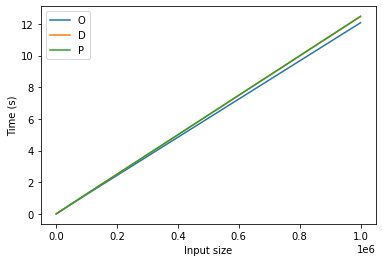

In [38]:
for k, v in times.items():
    plt.plot(data_sizes, [v[d_s]/nb_iter/nb_sub_iter for d_s in data_sizes], label=k)
plt.legend()
plt.xlabel("Input size")
plt.ylabel("Time (s)")

The different implementations does not influence the execution speed for this configuration. However, DCube and PCube still have room for more optimization, so we can imagine a future scenario where that implementation is faster.

Also, the computation at each time step is pretty simple as each function only has a complexity of O(1). With more compute-intensive functions, we would be able to take advantage of lower level language features to improve the performance.